In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('data/train_data_pipelineTest.csv')

# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1)

# # Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# # "Cardinality" means the number of unique values in a column
# # Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# # Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# # Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

#### We construct the full pipeline in three steps.

Step 1: Define Preprocessing Steps

In [177]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Step 2: Define the Model

In [178]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

Step 3: Create and Evaluate the Pipeline

In [179]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore",category=DeprecationWarning)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


pipeline_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model)
                                 ])

kfold = StratifiedKFold(n_splits=5, random_state=0)
score = cross_val_score(pipeline_model, X, y, cv=kfold)

# print accuracy from kfolds
print("Avg Accuracy: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

C:\Users\samer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\samer\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Avg Accuracy: 82.79% (5.24%)


In [180]:
# # Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_valid = my_pipeline.transform(X_valid)

# Fit the model
model.fit(X_train, y_train, 
          early_stopping_rounds=5, 
          eval_set=[(X_valid, y_valid)], 
          verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [181]:
# Get predictions
preds = model.predict(X_valid)

In [161]:
from sklearn.metrics import r2_score

print('Training score: ', model.score(X_train, y_train))
print('Testing score: ', r2_score(y_valid, preds))

Training score:  0.96333228554376
Testing score:  0.8531847872353149


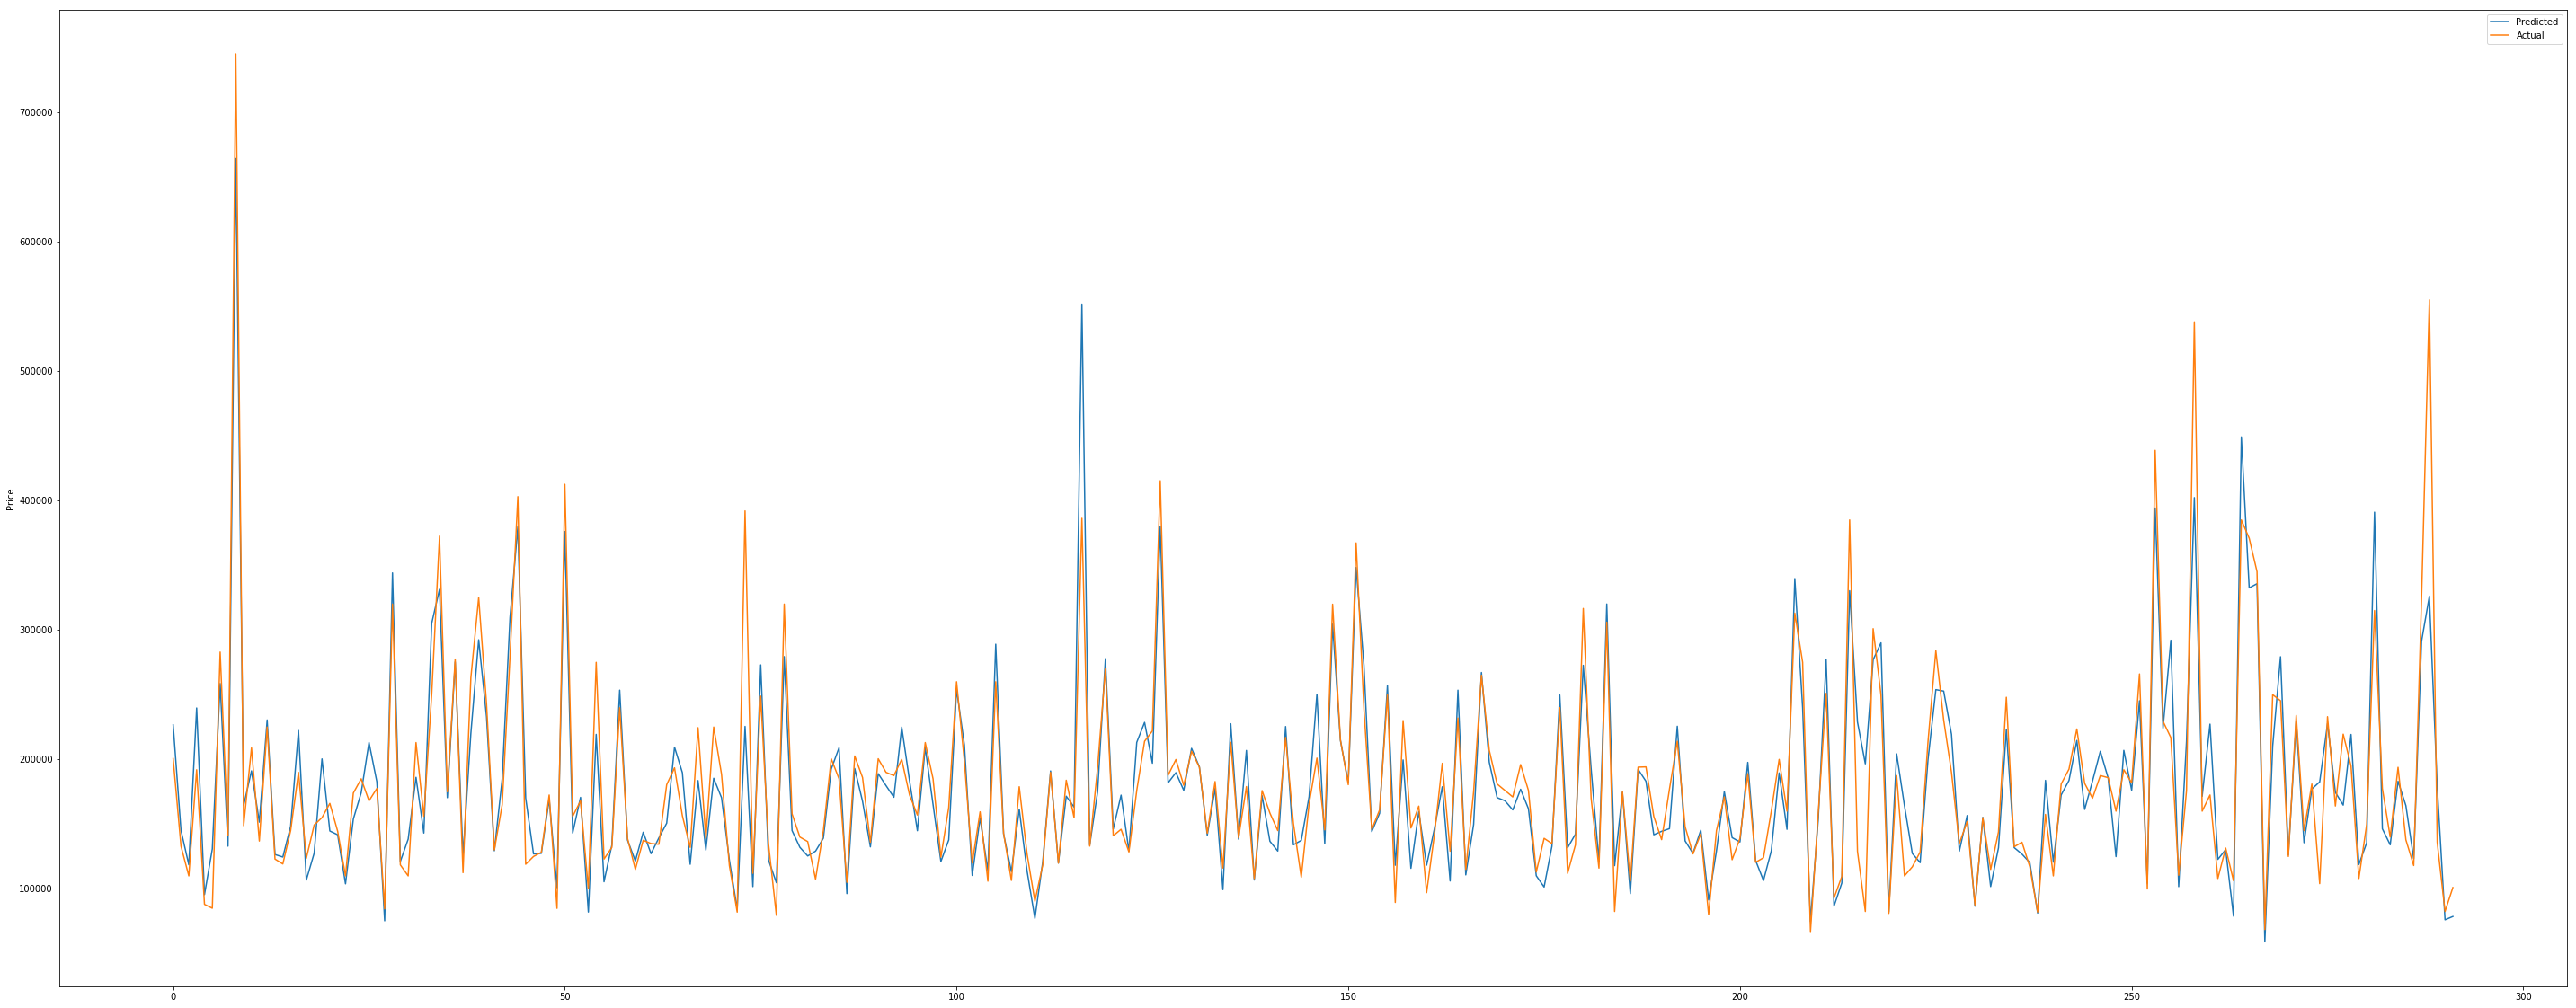

In [162]:
plt.figure(figsize = (50,20))

plt.plot(preds, label='Predicted')
plt.plot(y_valid.values, label='Actual')

plt.ylabel('Price')

plt.legend()
plt.show()

### Predict new data

In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Read the data
new_data = pd.read_csv('data/test.csv')

# Pick the columns we need to include in the model based on EDA
X_data = new_data[my_cols]

# "Cardinality" means the number of unique values in a column
## Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_data.columns if X_data[cname].nunique() < 10 and 
                        X_data[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_data.columns if X_data[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
# my_cols = categorical_cols + numerical_cols
# X_data = X_data[my_cols].copy()

##### Define Preprocessing Steps ####
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Preprocessing of data, get predictions
preds = pipeline_model.predict(X_data)

df_submission = pd.DataFrame({'Id': new_data.Id, 'SalePrice' : preds})

df_submission

,Id,SalePrice
0,1461,124286.335938
1,1462,146009.781250
2,1463,154806.328125
3,1464,180205.656250
4,1465,207934.453125
...,...,...
1454,2915,76085.507812
1455,2916,83731.937500
1456,2917,154220.203125
1457,2918,107480.367188
